In [1]:
import os
import time 
import math
import pickle
from contextlib import nullcontext

import numpy as np
import torch 
import torch.nn.functional as F

from tqdm import tqdm

from model import GPTConfig, GPT

In [2]:
out_dir = "/raid/slee3473/LLM/shakespeare_word/out"
if not os.path.exists(out_dir): raise RuntimeError(f"No out_dir {out_dir}")
    
eval_interval = 5
eval_iters = 40
ckpt_iters = 1000
# log_iters = 100
init_from = "gpt2"  # gpt2-xl ...
dataset = "shakespeare" # "openwebtext"
gradient_accumulation_steps = 1
batch_size = 1
block_size = 1024

n_layer = 12
n_head = 12
n_embed = 768
dropout = 0.0
bias = False

# AdamW optimizer settings
learning_rate = 3e-5  # 6e-4
max_iters = 2000
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0

# lr decay settings
decay_lr = False
warmup_iters = 2000
min_lr = 6e-5

# misc
device = "cuda:6"
dtype = "bfloat16"
master_process = True
seed_offset = 0
ddp_world_size = 1

torch.manual_seed(1337+seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True 
torch.backends.cudnn.allow_tf32 = True
device_type = "cuda"
ptdtype = torch.bfloat16  # {"float32": torch.float32, "bfloat16": torch.bfloat16, "float16": torch.float16}[dtype]
ctx = torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16)

In [3]:
data_dir = os.path.join("./../nanoGPT/data", dataset)
train_data = np.memmap(os.path.join(data_dir, "train.bin"), dtype=np.uint16, mode="r")
val_data = np.memmap(os.path.join(data_dir, "val.bin"), dtype=np.uint16, mode="r")

In [8]:
len(train_data)
# print(decode(train_data[0:1000].tolist()))

301966

In [4]:
def get_batch(split, return_idx=False):
    data = train_data if split =="train" else val_data 
    ix = torch.randint(len(data)-block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix]).pin_memory().to(device, non_blocking=True)
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix]).pin_memory().to(device, non_blocking=True)
    if return_idx: return x,y,ix
    return x, y

In [43]:
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embed, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout)
override_args = dict(dropout=dropout)
model = GPT.from_pretrained(init_from, override_args)
for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
    model_args[k] = getattr(model.config, k)
model = model.to(device)

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M


In [44]:
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)
checkpoint = None # free up memory

num decayed parameter tensors: 50, with 124,318,464 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True


In [45]:
@torch.no_grad()
def model_eval(model=model):
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X,Y = get_batch("val")
        with ctx: logits, loss = model(X,Y)
        losses[k] = loss.item()
    model.train()
    return losses.mean()

In [46]:
def save_ckpt(model=model, save_name=None):
    assert save_name is not None
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "model_args": model_args
#         TODO: SAVE TRAINING DATA INDEX
    }
    torch.save(checkpoint, save_name)
    print(f"Saved checkpoint at {save_name}")

In [6]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
decode = lambda l: enc.decode(l)

In [49]:
def get_attr_Y_prob(model, attr_X, attr_Y):
    model.eval()
    
    attr_logits, _ = model(attr_X)  # attr_logits: 1x1x50257
    attr_logits = attr_logits[:,-1,:] / 1. # temperature  # attr_logits: 1x50257
    v, _ = torch.topk(attr_logits, min(200, attr_logits.size(-1)))
    attr_logits[attr_logits < v[:,[-1]]] = -float("Inf")
    probs = F.softmax(attr_logits, dim=-1)  # 1x50257
    attr_Y_prob = probs[0, attr_Y.item()]
    
    model.train()
    return attr_Y_prob

In [50]:
attr_flag = True

if attr_flag:
    attr_X_str = "\n\n\nTHOMAS MOWBRAY:\nIt is a bloody tale:\nThe faultless traitor, whose blood hath paid\nThe thousand marks of honour, hath inveighed\nAgainst the proud and lowly royal.\n\n\n"
    attr_Y_str = "KING"
    attr_X = (torch.tensor(encode(attr_X_str), dtype=torch.long, device=device)[None, ...])
    attr_Y = (torch.tensor(encode(attr_Y_str), dtype=torch.long, device=device)[None, ...])
    
    attr_Y_prob_history = []
    attr_Y_prob = get_attr_Y_prob(model, attr_X, attr_Y)
    attr_Y_prob_history.append(attr_Y_prob.item())

In [51]:
attr_Y_prob_history

[0.006330428179353476]

In [52]:
num_epochs = 1
ckpt_flag = True
print(f"Before training eval loss: {model_eval():.4f}")

iter_i = 0
ckpt_data_idx_dict = dict()

# start training
model.train()
while True:
    if ckpt_flag and iter_i % ckpt_iters == 0: 
        save_name = f"ckpt_{iter_i}.pt"
        save_ckpt(model, os.path.join(out_dir, save_name))
        ckpt_data_idx_dict[save_name] = np.array([])
    if iter_i >= max_iters: break

    X, Y, idx = get_batch("train", return_idx=True)
    if ckpt_flag:
        ckpt_data_idx_dict[save_name] = np.concatenate([ckpt_data_idx_dict[save_name], idx])
    with ctx:
        logits, loss = model(X,Y)
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad(set_to_none=True)
    
    # Save history of probability changes
    if attr_flag:
        attr_Y_prob = get_attr_Y_prob(model, attr_X, attr_Y)
        attr_Y_prob_history.append(attr_Y_prob.item())

    iter_i += 1

    if iter_i % 100 == 0: print(f"Iter {iter_i} --- Loss: {loss.item()}")

Before training eval loss: 3.9854
Saved checkpoint at /raid/slee3473/LLM/shakespeare_word/out/ckpt_0.pt
Iter 100 --- Loss: 2.954612970352173
Iter 200 --- Loss: 3.3888134956359863
Iter 300 --- Loss: 3.0719399452209473
Iter 400 --- Loss: 3.295539140701294
Iter 500 --- Loss: 2.834326982498169
Iter 600 --- Loss: 3.0856497287750244
Iter 700 --- Loss: 3.0079500675201416
Iter 800 --- Loss: 3.2608802318573
Iter 900 --- Loss: 3.2390453815460205
Iter 1000 --- Loss: 3.1491498947143555
Saved checkpoint at /raid/slee3473/LLM/shakespeare_word/out/ckpt_1000.pt
Iter 1100 --- Loss: 3.043788194656372
Iter 1200 --- Loss: 2.7743775844573975
Iter 1300 --- Loss: 2.9975016117095947
Iter 1400 --- Loss: 2.8243560791015625
Iter 1500 --- Loss: 3.099839448928833
Iter 1600 --- Loss: 2.6417627334594727
Iter 1700 --- Loss: 2.9065773487091064
Iter 1800 --- Loss: 2.541936159133911
Iter 1900 --- Loss: 2.2222819328308105
Iter 2000 --- Loss: 2.6747512817382812
Saved checkpoint at /raid/slee3473/LLM/shakespeare_word/out/c

In [53]:
model_eval()

tensor(3.5882)

### See how the attr_Y_prob changes during training

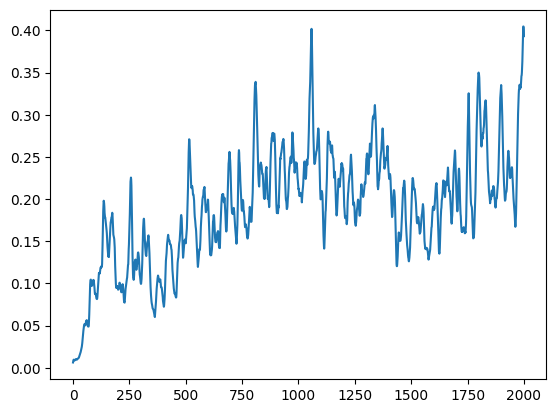

In [55]:
from matplotlib import pyplot as plt

plt.plot(np.array(attr_Y_prob_history))
# print(np.exp(np.array(attr_Y_prob_history)))

In [62]:
attr_Y_prob_history_after = attr_Y_prob_history[1:]
attr_Y_prob_history_after.append(attr_Y_prob_history[-1])
attr_Y_prob_history_after = np.array(attr_Y_prob_history_after)
assert attr_Y_prob_history_after[0] == attr_Y_prob_history[1]
attr_Y_prob_history_prev = np.array(attr_Y_prob_history).copy()
attr_Y_prob_improve = (attr_Y_prob_history_after - attr_Y_prob_history_prev)[:-1]
biggest_improve_idx = np.argsort(attr_Y_prob_improve)

In [63]:
biggest_improve_idx[:10]

array([1063,  262, 1062, 1758, 1060,  263, 1759,  260, 1757, 1064])

In [66]:
for idx in biggest_improve_idx[:10]:
    ckpt_iter_idx = (idx//1000)*1000
    data_idx = ckpt_data_idx_dict[f"ckpt_{ckpt_iter_idx}.pt"][idx-ckpt_iter_idx]
    x = train_data[data_idx:data_idx+block_size].astype(np.int64)
    print(decode(x))
    print()

TypeError: slice indices must be integers or None or have an __index__ method

In [51]:
# 16->17: probability significantly decreased
# 11->12: probability significantly increased
# Probability change doesn't correlate with the characteristics of training data? (Why? Due to complex operations inside model?)
cnt_John = 0
cnt_name = 0
training_data_indices = ckpt_data_idx_dict["ckpt_0.pt"]
# print(np.exp(np.array(attr_Y_prob_history))[11])

for j in range(len(attr_Y_prob_history)-1):
    cnt_John, cnt_name = 0, 0
    for i in training_data_indices[j*gradient_accumulation_steps:(j+1)*gradient_accumulation_steps]:
        i = int(i)
        if "John" in decode(train_data[i:i+block_size]): cnt_John += 1
        if "name" in decode(train_data[i:i+block_size]): cnt_name += 1
    print(f"{j}:", cnt_John, cnt_name)

0: 2 9
1: 3 12
2: 2 14
3: 2 15
4: 3 11
5: 0 16
6: 3 14
7: 2 14
8: 3 12
9: 2 10
10: 1 11
11: 0 15
12: 0 10
13: 1 16
14: 0 10
15: 1 11
16: 0 8
17: 1 12
18: 2 11
19: 3 12


### Generate

In [21]:
start = "\n"
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

In [23]:
model.eval()
model.to(device)

with torch.no_grad():
    with ctx:
        for k in range(2):
            y = model.generate(x, 200, temperature=0.8, top_k=200)
            print(decode(y[0].tolist()))
            print("====")


SICINIUS:
'Tis so:
it is a part of mine.

BRUTUS:
Give me some brass knapsack
And never toil for more
Than this, shall ever I know! Caesar, give me
A sceptre long enough to keep mine eyes open:
And you, my friends, in your fashions I'll prove
True friends, shall prove ever so faithful.

SICINIUS:
Will you buy more?

BRUTUS:
I will buy more.

SICINIUS:
I'll buy five times more!

BRUTUS:
Five times more!

SICINIUS:
Come, sir, let me understand.

VOLUMNIA:
I know your meaning,
And I know you mean well.

SICINIUS:
I know your meaning.

VOL
====


THOMAS MOWBRAY:
It is a bloody tale:
The faultless traitor, whose blood hath paid
The thousand marks of honour, hath inveighed
Against the proud and lowly royal.

KING RICHARD II:
Ah, madam, you do betray the king.
Why, my lord! what cause have you here?
Come home to dinner: we must meet one another,
And think we have met before?

THOMAS MOWBRAY:
Ay, but hardly a word now. What is your will?

KING RICHARD II:
Here lies my son slain and my cousin 

### Attribute something

In [21]:
attr_X_str = "My name is"
attr_Y_str = " John"
attr_X = (torch.tensor(encode(attr_X_str), dtype=torch.long, device=device)[None, ...])
attr_Y = (torch.tensor(encode(attr_Y_str), dtype=torch.long, device=device)[None, ...])

In [28]:
model.eval()    
    
attr_logits, _ = model(attr_X)    
attr_logits = attr_logits[:,-1,:] / 1. # temperature  # attr_logits: 1x50257
v, _ = torch.topk(attr_logits, min(200, attr_logits.size(-1)))
attr_logits[attr_logits < v[:,[-1]]] = -float("Inf")
prob = F.softmax(attr_logits, dim=-1)
print(f"Probability of {attr_Y_str} to come after {attr_X_str}:", prob[0,attr_Y.item()].item())

Probability of  John to come after My name is: 0.04871632531285286


In [19]:
def tuple_inner_product(t1, t2, device=device):
    assert len(t1) == len(t2)

    inner = 0
    for d1, d2 in zip(t1, t2):
        d1 = d1.to(device)
        d2 = d2.to(device)
        assert torch.numel(d1) == torch.numel(d2)
        inner += torch.inner(d1.flatten(), d2.flatten())

    return inner

In [20]:
def load_ckpt(ckpt_name="ckpt.pt", ckpt_dir=out_dir, device=device):
    ckpt = torch.load(os.path.join(ckpt_dir, ckpt_name), map_location=device)
    
    ckpt_state_dict = ckpt["model"]
    ckpt_model_args = ckpt["model_args"]
    ckpt_opt_args = ckpt["optimizer"]
    # TODO: LOAD TRAINING DATA INDEX
    
    ckpt_config = GPTConfig(**ckpt_model_args)
    ckpt_model = GPT(ckpt_config).to(device)
    ckpt_model.load_state_dict(ckpt_state_dict)

    print(f"Loaded checkpoint model {ckpt_name}")

    return ckpt_model

In [49]:
model.eval()
influence_scores = np.zeros(len(train_data))
start = time.time()
time_log_iters = 100
ckpt_names = []

for i in range(max_iters//ckpt_iters+1):
    ckpt_names.append(f"ckpt_{i*ckpt_iters}.pt")
    
for ckpt_name in ckpt_names:
    ckpt_model = load_ckpt(ckpt_name=ckpt_name)
    ckpt_model.eval()

    attr_logits, _ = ckpt_model(attr_X)  # attr_logits: 1x1x50257
    attr_logits = attr_logits[:,-1,:] / 1. # temperature  # attr_logits: 1x50257
    v, _ = torch.topk(attr_logits, min(200, attr_logits.size(-1)))
    attr_logits[attr_logits < v[:,[-1]]] = -float("Inf")
    probs = F.log_softmax(attr_logits, dim=-1)  # 1x50257
    attr_Y_prob = probs[0, attr_Y.item()]
    attr_Y_prob_gradient = torch.autograd.grad(attr_Y_prob, ckpt_model.parameters())

    training_data_indices = ckpt_data_idx_dict[ckpt_name]  # TODO: replace it with the loaded one
    training_data_index_pointer = 0

    for i in tqdm(training_data_indices.astype(int)):
        X = torch.unsqueeze(torch.from_numpy((train_data[i:i+block_size]).astype(np.int64)).pin_memory().to(device, non_blocking=True), 0)
        Y = torch.unsqueeze(torch.from_numpy((train_data[i+1:i+1+block_size]).astype(np.int64)).pin_memory().to(device, non_blocking=True), 0)
        logits, loss = ckpt_model(X, Y)
        training_gradient = torch.autograd.grad(loss, ckpt_model.parameters())
        influence_scores[i] += tuple_inner_product(training_gradient, attr_Y_prob_gradient)

100%|████████████████████████████████████████████| 640/640 [02:39<00:00,  4.01it/s]


In [50]:
influential_sorted = np.argsort(influence_scores)

In [51]:
for i in influential_sorted[:1]:
    print(f"{i}-th training data with score {influence_scores[i]}")
    print(decode(train_data[i:i+block_size]))
    print("name" in decode(train_data[i:i+block_size]))
    print()

7132-th training data with score -1.4036084413528442
 sir, thou bleed'st;
Thy exercise hath been too violent for
A second course of fight.

MARCIUS:
Sir, praise me not;
My work hath yet not warm'd me: fare you well:
The blood I drop is rather physical
Than dangerous to me: to Aufidius thus
I will appear, and fight.

LARTIUS:
Now the fair goddess, Fortune,
Fall deep in love with thee; and her great charms
Misguide thy opposers' swords! Bold gentleman,
Prosperity be thy page!

MARCIUS:
Thy friend no less
Than those she placeth highest! So, farewell.

LARTIUS:
Thou worthiest Marcius!
Go, sound thy trumpet in the market-place;
Call thither all the officers o' the town,
Where they shall know our mind: away!

COMINIUS:
Breathe you, my friends: well fought;
we are come off
Like Romans, neither foolish in our stands,
Nor cowardly in retire: believe me, sirs,
We shall be charged again. Whiles we have struck,
By interims and conveying gusts we have heard
The charges of our friends. Ye Roman gods